# Trực quan hóa dữ liệu 

Notebook này trực quan hóa bộ `processed_data.csv` (World Bank 2000-2024) để nhanh chóng nắm bắt sự thay đổi về tăng trưởng kinh tế, chất lượng sống,... và các yếu tố khác.


## Mục tiêu
- Tóm tắt cấu trúc dữ liệu sau bước tiền xử lý.
- Minh họa các xu hướng chính bằng những biểu đồ quen thuộc của `seaborn` và `matplotlib`.
- Ghi lại insight có thể hành động ngay sau mỗi biểu đồ.


## Quy trình thực hiện
1. Chuẩn bị môi trường (thư viện, theme đồ họa).
2. Đọc dữ liệu đã làm sạch và rà soát sơ bộ.
3. Dựng từng nhóm biểu đồ (kinh tế, phúc lợi, hạ tầng, môi trường) kèm giải thích chi tiết.
4. Tổng hợp insight cuối notebook để tiện tham chiếu nhanh.


## Bước 1 - Chuẩn bị môi trường
Import các thư viện nền tảng và thiết lập style tối giản để biểu đồ nhất quán giữa các bước.


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120
pd.options.display.float_format = lambda x: f"{x:,.2f}"

DATA_PATH = Path("../data/processed/processed_data.csv")
DATA_PATH


WindowsPath('../data/processed/processed_data.csv')

## Bước 2 - Đọc dữ liệu


In [31]:
df = pd.read_csv(DATA_PATH)

df["year"] = df["year"].astype(int)

print(f"Số dòng: {df.shape[0]}\nSố cột: {df.shape[1]}")
df.head()

Số dòng: 5425
Số cột: 13


,country_name,country_code,year,population,pop_growth,life_expectancy,gdp_per_capita,gdp_growth,sanitation,electricity,water_access,co2_emissions,labor_force
0,Aruba,ABW,2000,"90,588.00",1.03,72.94,"20,681.02",7.62,51.96,91.70,94.49,2.97,60.90
1,Aruba,ABW,2001,"91,439.00",0.94,73.04,"20,740.13",4.18,51.96,100.00,94.77,2.97,60.90
2,Aruba,ABW,2002,"92,074.00",0.69,73.14,"21,307.25",-0.94,51.96,100.00,95.05,3.22,60.90
3,Aruba,ABW,2003,"93,128.00",1.14,73.24,"21,949.49",1.11,51.96,100.00,95.33,3.67,60.90
4,Aruba,ABW,2004,"95,138.00",2.14,73.22,"23,700.63",7.29,51.96,100.00,95.62,3.67,60.90


## Bước 3 - Khoanh vùng các biến quan trọng quyết định tới tuổi thọ

### Mục tiêu:
- Làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá)
- Tính tương quan Pearson giữa từng biến và `life_expectancy`


### 3.1. Tính tương quan Pearson giữa từng biến và `life_expectancy`

In [32]:
feature_cols = [
    col for col in df.columns
    if col not in ["country_name", "country_code", "life_expectancy"]
]
target_col = "life_expectancy"

numeric_df = df[feature_cols + [target_col]]
life_corr_matrix = numeric_df.corr(numeric_only=True)
life_corr_with_target = life_corr_matrix[target_col].drop(target_col)
life_feature_signal = (
    life_corr_with_target.to_frame(name="corr_with_life")
    .assign(abs_corr=lambda df_: df_["corr_with_life"].abs())
    .sort_values("abs_corr", ascending=False)
)
top_life_features = life_feature_signal.head().index.tolist()

display(life_feature_signal.head(10))


,corr_with_life,abs_corr
electricity,0.80,0.80
water_access,0.80,0.80
sanitation,0.59,0.59
gdp_per_capita,0.56,0.56
pop_growth,-0.31,0.31
co2_emissions,0.28,0.28
year,0.20,0.20
labor_force,-0.12,0.12
gdp_growth,-0.11,0.11
population,-0.00,0.00


Qua bảng này, ta nhận thấy các biến `electricity`, `water_access`, `sanitation` và `gdp_per_capital` có chỉ số tương quan lớn với biến mục tiêu `life_expectancy` (chỉ số đều lớn hơn 0.5). Do đó, ta sẽ tập trung đi phân tích các biến này.

### 3.2. Kiểm tra phân phối của các chỉ số hạ tầng cơ bản
Vẽ histogram + KDE cho `electricity`, `water_access`, `sanitation` (các thuộc tính thể hiện các chỉ số hạ tầng cơ bản) để quan sát phân phối và độ lệch dữ liệu.


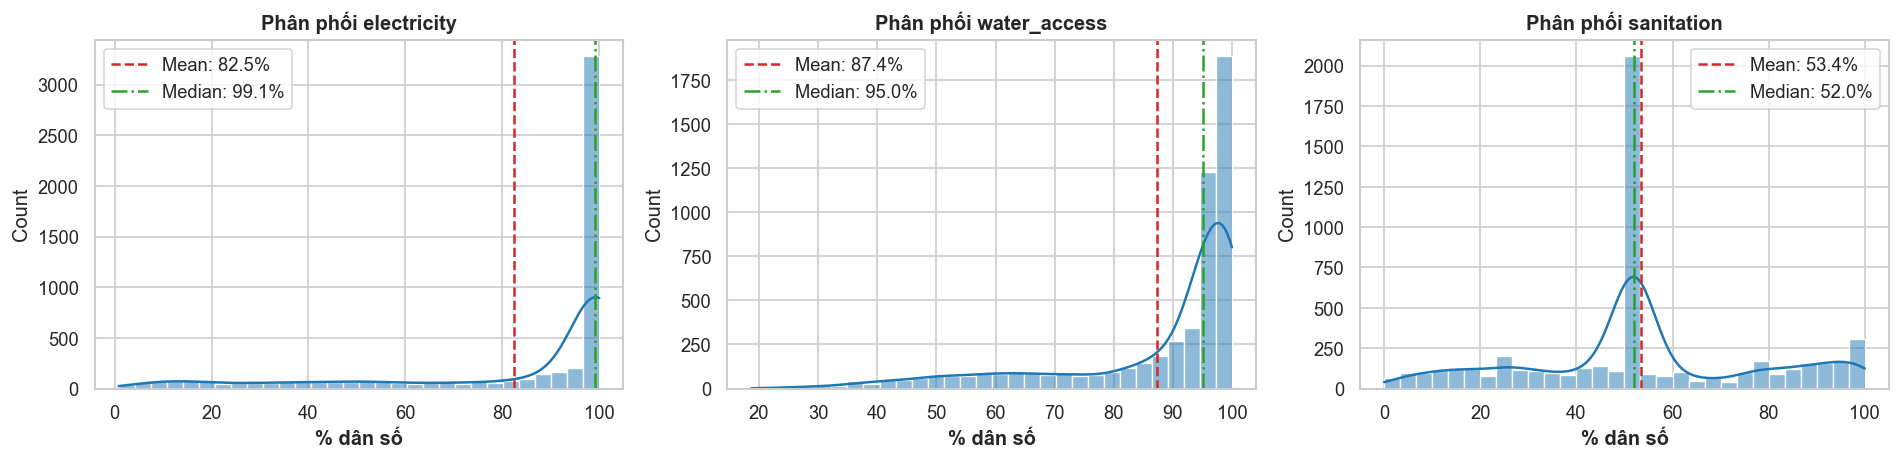

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, indicator in zip(axes, ['electricity', 'water_access', 'sanitation']):
    sns.histplot(df[indicator], bins=30, kde=True, ax=ax, color='#1f77b4')
    mean_val = df[indicator].mean()
    median_val = df[indicator].median()
    ax.axvline(mean_val, color='#d62728', linestyle='--', label=f'Mean: {mean_val:.1f}%')
    ax.axvline(median_val, color='#2ca02c', linestyle='-.', label=f'Median: {median_val:.1f}%')
    ax.set_title(f'Phân phối {indicator}', fontweight='bold')
    ax.set_xlabel('% dân số', fontweight='bold')
    ax.legend()

plt.tight_layout()


Nhận xét: 
- Phân phối của hai biến `electricity` và `water_access` đều lệch phải, tồn tại quốc gia có độ phủ rất thấp kéo giá trị trung bình (mean) xuống.
- Có sự chênh lệch rất lớn giữa các quốc gia có chỉ số hạ tầng cơ bản cao và các quốc gia có chỉ số hạ tầng cơ bản thấp.



### 3.3. Xây dựng các bảng dữ liệu hỗ trợ cho việc phân tích

Ta tiến hành gộp dữ liệu hiện có theo năm, giữ lại giá trị các biến có mối tương quan cao với biến mục tiêu là `electricity`, `water_access`, `sanitation` và `gdp_per_capita`. 

Với các giá trị được gộp, ta gộp theo trung vị (median) của từng biến do sự chênh lệch trong phân phối dữ liệu các biến đã được chỉ ra ở các phần trước.

In [36]:
# Bảng tổng hợp giữa điện, nước và vệ sinh (dùng median theo năm để giảm ảnh hưởng outlier)
services_trend = (
    df.groupby("year")[['electricity', 'water_access', 'sanitation']]
      .median()
      .reset_index()
      .melt(id_vars="year", var_name="indicator", value_name="coverage")
)

# Xu hướng median GDP theo năm
gdp_trend = (
    df.groupby("year")[ ["gdp_per_capita"] ]
      .median()
      .reset_index()
      .rename(columns={"gdp_per_capita": "median_gdp_per_capita"})
)

latest_year = int(df["year"].max())
baseline_year = int(df["year"].min())

# Top 10 nước có GDP cao nhất
top_gdp_latest = (
    df[df["year"] == latest_year][["country_name", "gdp_per_capita"]]
      .dropna()
      .nlargest(10, "gdp_per_capita")
      .sort_values("gdp_per_capita", ascending=False)
)

gdp_quantiles = df["gdp_per_capita"].quantile([0.10, 0.50, 0.90])
life_quantiles = df["life_expectancy"].quantile([0.10, 0.50, 0.90])
corr_gdp_life = float(life_corr_matrix.loc["gdp_per_capita", "life_expectancy"])

def service_value(indicator: str, year: int) -> float:
  return float(
      services_trend.loc[
          (services_trend["year"] == year) & (services_trend["indicator"] == indicator),
          "coverage"
      ].iloc[0]
  )

# Lưu các thông tin quan trọng vào dictionary để phục vụ cho việc trực quan hóa sau này
insight_stats = {
    "median_gdp_baseline": float(gdp_trend.loc[gdp_trend["year"] == baseline_year, "median_gdp_per_capita"].iloc[0]),
    "median_gdp_latest": float(gdp_trend.loc[gdp_trend["year"] == latest_year, "median_gdp_per_capita"].iloc[0]),
    "median_electricity_baseline": service_value("electricity", baseline_year),
    "median_electricity_latest": service_value("electricity", latest_year),
    "median_water_baseline": service_value("water_access", baseline_year),
    "median_water_latest": service_value("water_access", latest_year),
    "median_sanitation_baseline": service_value("sanitation", baseline_year),
    "median_sanitation_latest": service_value("sanitation", latest_year),
    "gdp_q10": float(gdp_quantiles.loc[0.10]),
    "gdp_q50": float(gdp_quantiles.loc[0.50]),
    "gdp_q90": float(gdp_quantiles.loc[0.90]),
    "life_q10": float(life_quantiles.loc[0.10]),
    "life_q50": float(life_quantiles.loc[0.50]),
    "life_q90": float(life_quantiles.loc[0.90]),
    "corr_gdp_life": corr_gdp_life,
    "latest_year": latest_year,
    "baseline_year": baseline_year,
    "country_count": int(df["country_name"].nunique()),
}
display(insight_stats)


{'median_gdp_baseline': 2199.04465936314,
 'median_gdp_latest': 6073.61032342708,
 'median_electricity_baseline': 97.0,
 'median_electricity_latest': 99.1,
 'median_water_baseline': 93.5641620053584,
 'median_water_latest': 95.0253353861125,
 'median_sanitation_baseline': 51.9572656003284,
 'median_sanitation_latest': 51.9572656003284,
 'gdp_q10': 681.4742755139864,
 'gdp_q50': 5477.03712389913,
 'gdp_q90': 44977.59380774997,
 'life_q10': 58.7098,
 'life_q50': 72.60300000000001,
 'life_q90': 81.1756097560976,
 'corr_gdp_life': 0.5563811440033944,
 'latest_year': 2024,
 'baseline_year': 2000,
 'country_count': 217}

## Bước 4. Trực quan hóa & insight chi tiết
Các biểu đồ dưới đây làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá) và tập trung vào các biến tương quan cao với `life_expectancy` (`GDP_per_capita`, `water_access`,...)


### 4.1. Phân tích phân phối GDP bình quân đầu người và tuổi thọ
Tại bước này, ta nhóm tất cả dữ liệu theo năm, dữ liệu của các quốc gia khác nhau được tính theo median để cho ra kết quả cuối cùng (median GDP bình quân đầu người). Kết quả này sẽ được dùng để phân tích trên biểu đồ.

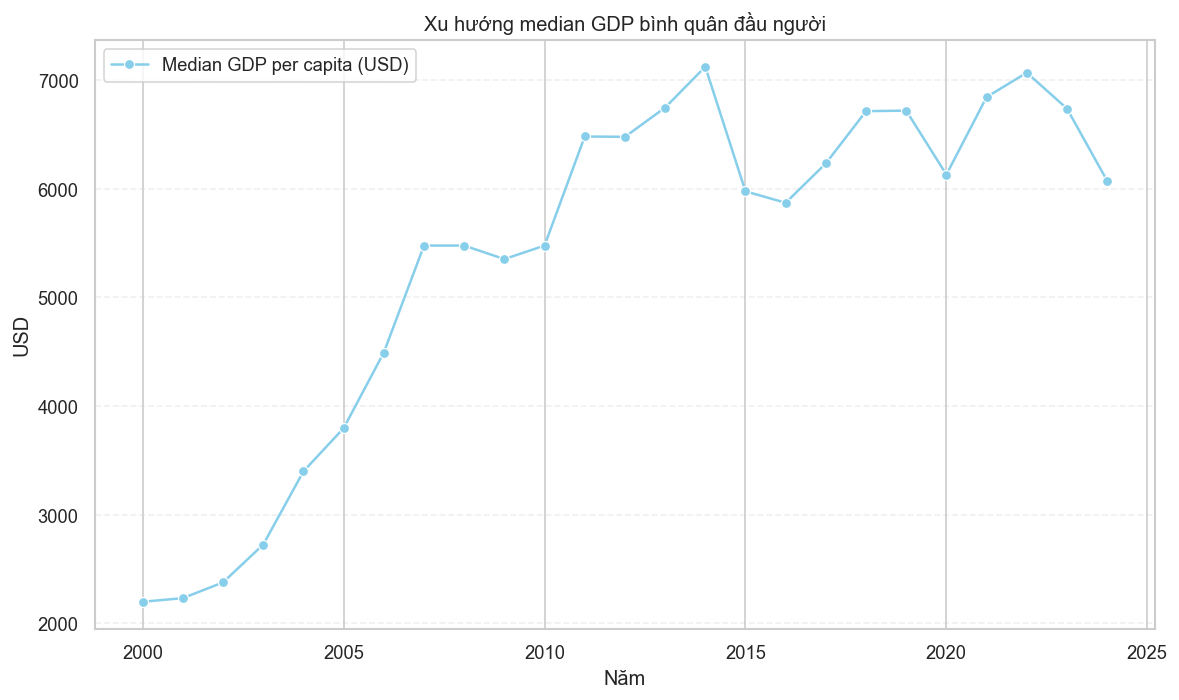

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=gdp_trend,
    x="year",
    y="median_gdp_per_capita",
    marker="o",
    ax=ax1,
    color="skyblue",
    label="Median GDP per capita (USD)"
)
ax1.set_ylabel("USD")
ax1.set_xlabel("Năm")
ax1.set_title("Xu hướng median GDP bình quân đầu người")
ax1.grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()


**Insight:** Median GDP bình quân đầu người tăng rõ rệt theo thời gian (từ mức thấp đầu giai đoạn 2000 lên cao hơn ở 2024), phản ánh xu hướng tăng trưởng thu nhập chung của dân số thế giới.

### 4.2 Phân phối GDP bình quân và tuổi thọ
Tại bước này, ta sử dụng biểu đồ histogram để thể hiện phân phối của hai biến: GDP bình quân đầu người (`GDP per capita`) và tuổi thọ trung bình (`life_expectancy`). Đồng thời, thêm các đường phần trăm (10/50/90) để thể hiện rõ sự chênh lệch thu nhập và chênh lệch tuổi thọ của từng nhóm quốc gia.


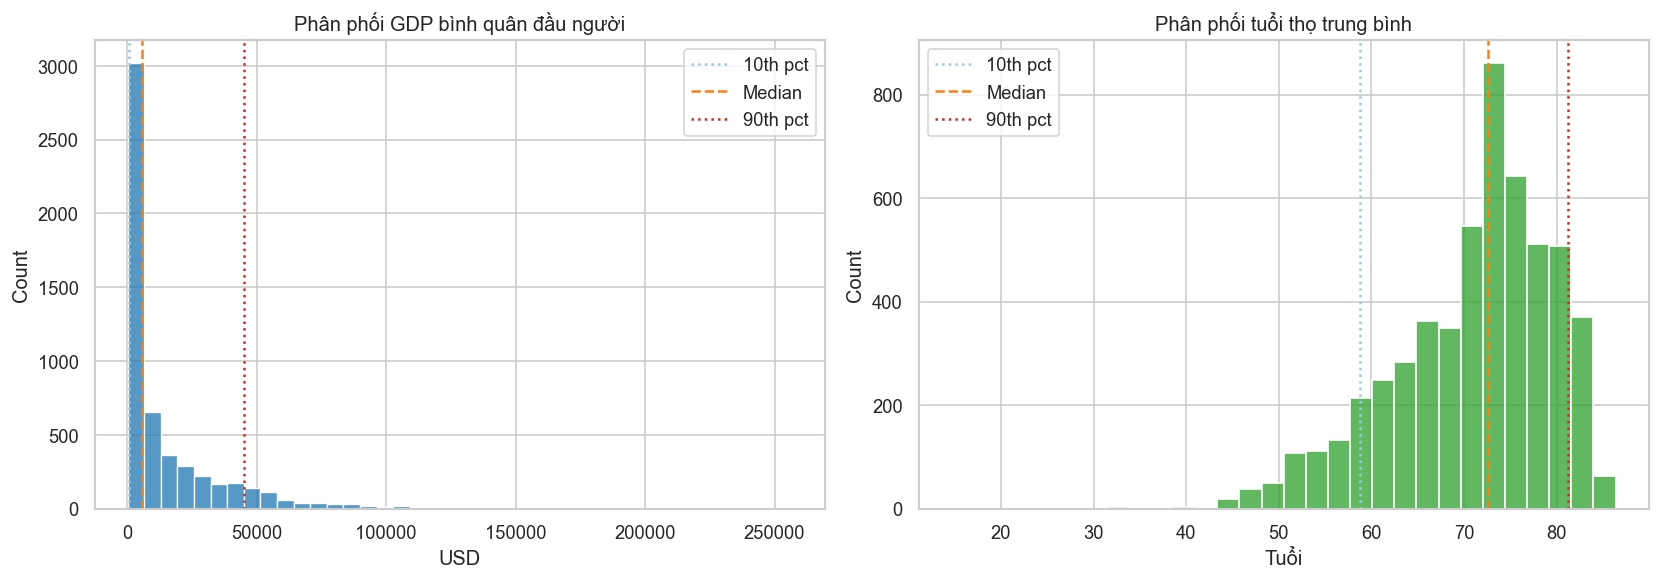

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["gdp_per_capita"], bins=40, ax=axes[0], color="#1f77b4")
axes[0].axvline(insight_stats["gdp_q10"], color="#9ecae1", linestyle=":", label="10th pct")
axes[0].axvline(insight_stats["gdp_q50"], color="#ff7f0e", linestyle="--", label="Median")
axes[0].axvline(insight_stats["gdp_q90"], color="#d62728", linestyle=":", label="90th pct")
axes[0].set_title("Phân phối GDP bình quân đầu người")
axes[0].set_xlabel("USD")
axes[0].legend()

sns.histplot(df["life_expectancy"], bins=30, ax=axes[1], color="#2ca02c")
axes[1].axvline(insight_stats["life_q10"], color="#9ecae1", linestyle=":", label="10th pct")
axes[1].axvline(insight_stats["life_q50"], color="#ff7f0e", linestyle="--", label="Median")
axes[1].axvline(insight_stats["life_q90"], color="#d62728", linestyle=":", label="90th pct")
axes[1].set_title("Phân phối tuổi thọ trung bình")
axes[1].set_xlabel("Tuổi")
axes[1].legend()

plt.tight_layout()


**Insight 1:** 10% quốc gia có GDP <~0.7 nghìn USD, median ~5.5 nghìn USD trong khi 10% cao nhất vượt 45 nghìn USD. Điều này chứng tỏ khoảng cách thu nhập vẫn rất lớn giữa các quốc gia top đầu và quốc gia top dưới. Tuổi thọ tập trung ở mức 58.7-81.2 tuổi (trung vị 72.6 tuổi)

**Insight 2:** Đa số quốc gia có tuổi thọ từ 60-80 năm, median khoảng 73 năm; nhóm 10% thấp nhất chỉ quanh 58 năm trong khi nhóm 10% cao nhất vượt 80, cho thấy khoảng cách đáng kể trong chất lượng y tế/cơ sở hạ tầng xã hội.


### 4.3. Quan hệ giữa GDP bình quân và tuổi thọ
Ta sử dụng biểu đồ `regplot` để vẽ biểu đồ phân tán (scatter plot) kèm theo đường hồi quy, nhằm trực quan hóa mối quan hệ giữa hai thuộc tính.

Ở đây, ta sử dụng thang log ở trục X do đặc điểm của biến GDP (khoảng cách giàu nghèo giữa các quốc gia top đầu và quốc gia top cuối là rất lớn)


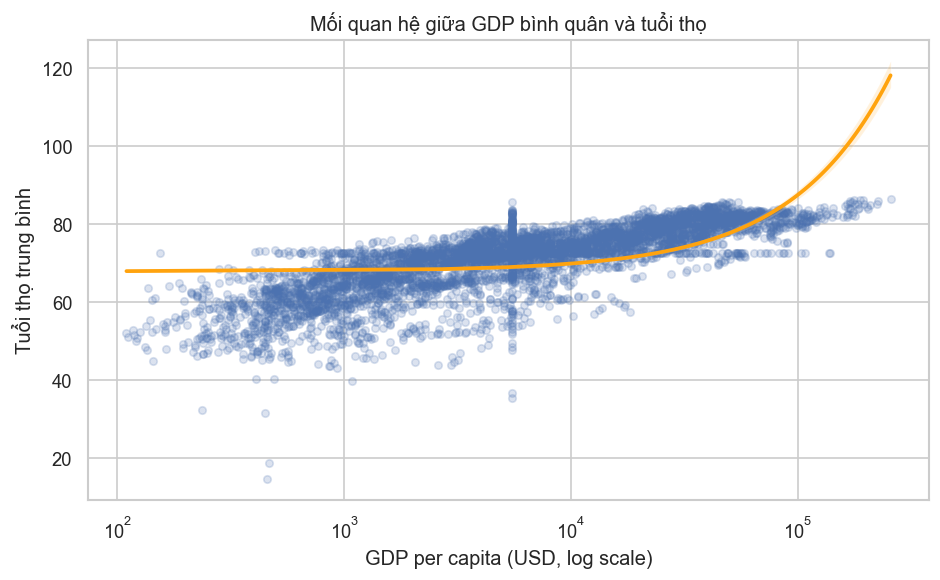

In [39]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x="gdp_per_capita",
    y="life_expectancy",
    scatter_kws={"alpha": 0.2, "s": 20},
    line_kws={"color": "#ffa30e"}
)
plt.xscale("log")
plt.xlabel("GDP per capita (USD, log scale)")
plt.ylabel("Tuổi thọ trung bình")
plt.title("Mối quan hệ giữa GDP bình quân và tuổi thọ")
plt.tight_layout()


**Insight:** Nhìn vào biểu đồ ta có thể thấy các quốc gia giàu hơn thường sống thọ hơn; tuy nhiên đường hồi quy phẳng dần từ ngưỡng ~20 nghìn USD, hàm ý muốn nâng tuổi thọ cần tập trung vào y tế và hạ tầng hơn là chỉ tăng thu nhập khi đã đạt mức này.


### 4.4. Phân tích các chỉ số hạ tầng cơ bản (`water_access`, `electricity`, `sanitation`)
Ta gộp dữ liệu theo từng năm, dữ liệu của các quốc gia khác nhau được tính trung vị (median) để phân tích xu hướng của các biến: `water_access`, `electricity` và `sanitation` theo thời gian.


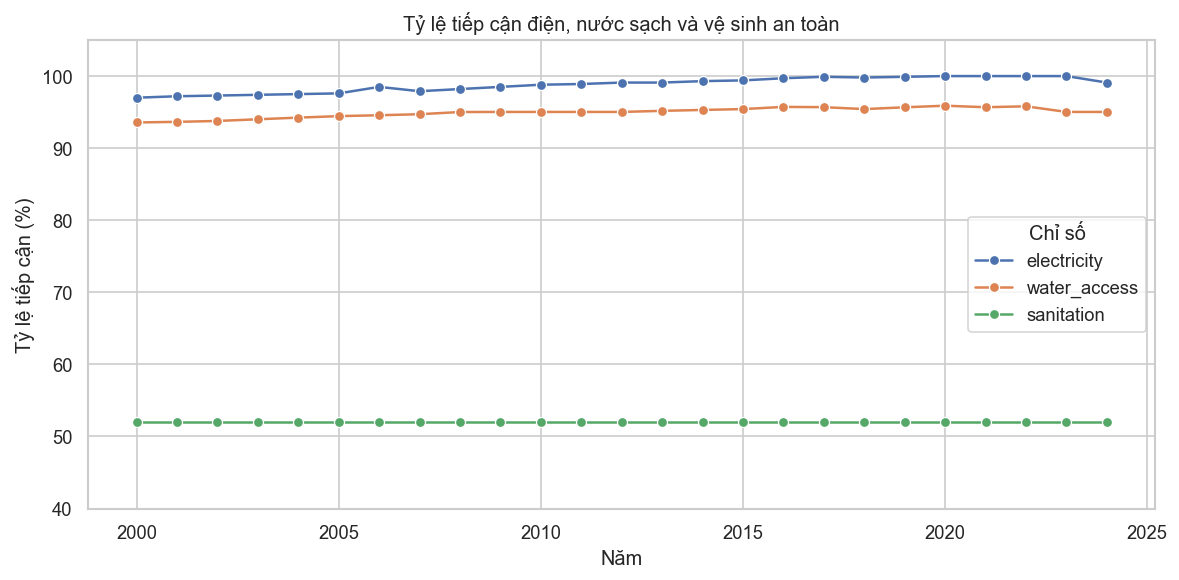

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=services_trend,
    x="year",
    y="coverage",
    hue="indicator",
    marker="o"
)
plt.ylim(40, 105)
plt.ylabel("Tỷ lệ tiếp cận (%)")
plt.xlabel("Năm")
plt.title("Tỷ lệ tiếp cận điện, nước sạch và vệ sinh an toàn")
plt.legend(title="Chỉ số")
plt.tight_layout()


**Insight:** Theo biểu đồ ta có thể thấy, `electricity` đã ở mức rất cao (~97%) ngay năm 2000 và gần bão hòa 99.1% vào năm 2024; `water_access` cũng chỉ nhích từ ~93.6% lên 95.0%. Ngược lại, `sanitation` giậm chân tại ~52% trong suốt giai đoạn từ năm 2000 - 2024, cho thấy nút thắt lớn nhất nằm ở `sanitation` dù các hạ tầng khác đã phát triển gần bão hòa.


### 4.5. Mối quan hệ giữa hạ tầng cơ bản với tuổi thọ
Phân tích trực tiếp mức độ phủ `sanitation`, `water_access` và `electricity` so với `life_expectancy` để xem biến hạ tầng nào gắn với tuổi thọ mạnh nhất.


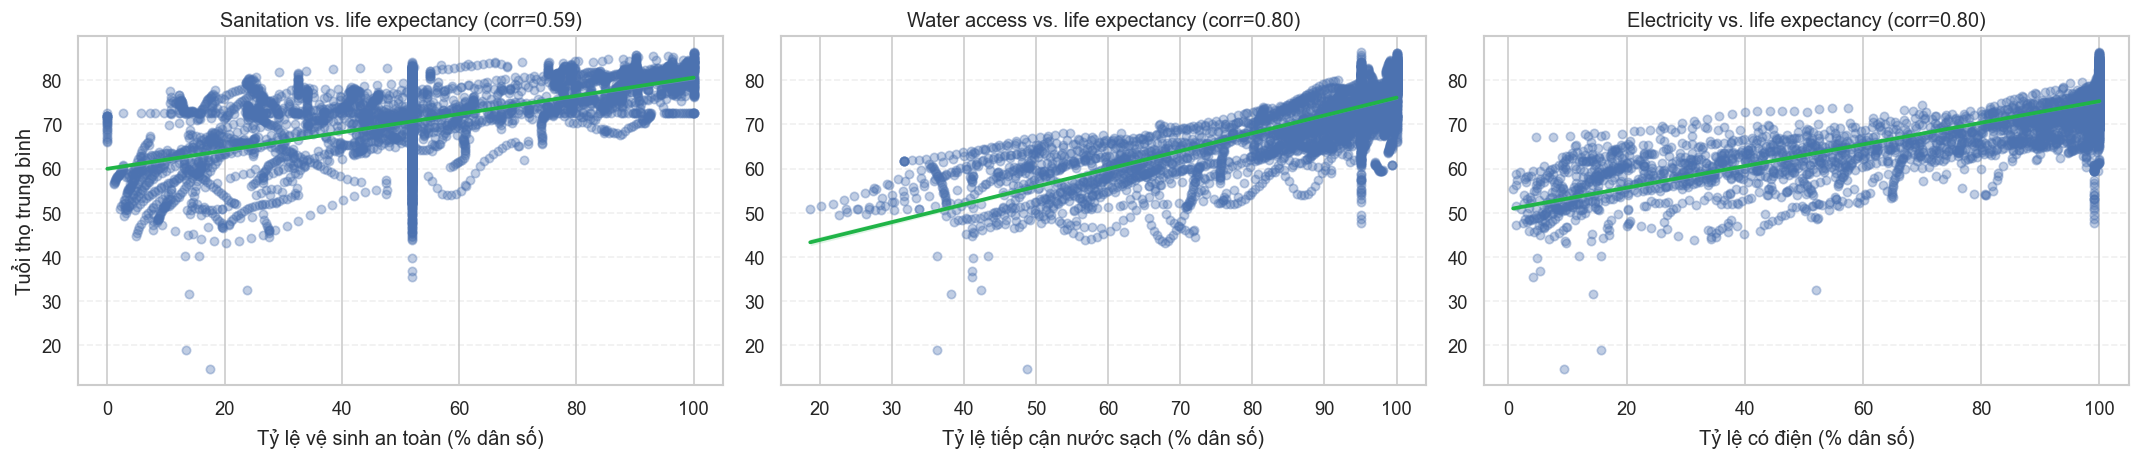

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

indicator_labels = {
    'sanitation': 'Tỷ lệ vệ sinh an toàn (% dân số)',
    'water_access': 'Tỷ lệ tiếp cận nước sạch (% dân số)',
    'electricity': 'Tỷ lệ có điện (% dân số)'
}
title_labels = {
    'sanitation': 'Sanitation vs. life expectancy',
    'water_access': 'Water access vs. life expectancy',
    'electricity': 'Electricity vs. life expectancy'
}

for ax, indicator in zip(axes, indicator_labels.keys()):
    sns.regplot(
        data=df,
        x=indicator,
        y='life_expectancy',
        scatter_kws={'alpha': 0.35, 's': 25},
        line_kws={'color': '#1fb447'},
        ax=ax
    )
    corr = df[[indicator, 'life_expectancy']].corr().iloc[0, 1]
    ax.set_title(f"{title_labels[indicator]} (corr={corr:.2f})")
    ax.set_xlabel(indicator_labels[indicator])
    ax.set_ylabel('Tuổi thọ trung bình' if indicator == 'sanitation' else '')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()


**Insight 1:** Điện và nước sạch có tương quan rất mạnh với tuổi thọ (r≈0.80), vệ sinh an toàn cũng dương nhưng yếu hơn (r≈0.59).

**Insight 2:** Nhóm có độ phủ điện/nước >95% thường đạt tuổi thọ >75; các quốc gia có sanitation <50% tập trung ở vùng tuổi thọ thấp, nên ưu tiên nâng vệ sinh để thu hẹp khoảng cách.


### 4.6. Top 10 quốc gia có GDP bình quân cao nhất (năm 2024)
Biểu đồ thanh ngang giúp xác định nhanh nhóm dẫn đầu để làm benchmark chính sách.


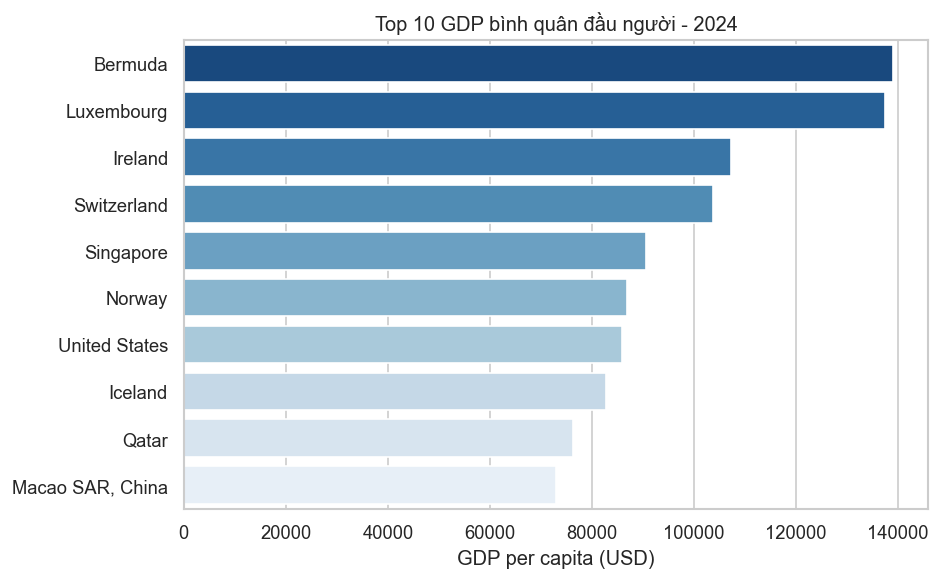

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=top_gdp_latest,
    x="gdp_per_capita",
    y="country_name",
    hue="country_name",
    palette="Blues_r",
    ax=ax
)
if ax.legend_ is not None:
    ax.legend_.remove()
ax.set_xlabel("GDP per capita (USD)")
ax.set_ylabel("")
ax.set_title(f"Top 10 GDP bình quân đầu người - {latest_year}")
plt.tight_layout()


**Insight:** Nhóm dẫn đầu gồm Bermuda, Luxembourg, Ireland, Switzerland và Singapore (>90 nghìn USD/người), tiếp theo là Mỹ và Na Uy (~85 nghìn USD). Khoảng cách rất lớn so với phần còn lại của thế giới.


## Bước 5. Tổng kết các insight chính
- Median GDP bình quân đầu người tăng ~175% (2.2k -> 6.1k USD) kéo theo tỷ lệ nghèo giảm về 5.2%, nhưng tốc độ giảm nghèo chững lại sau 2015.

- Khoảng cách thu nhập vẫn rất lớn (10th pct ~0.7k USD vs. 90th pct ~45k USD) và tuổi thọ của nhóm đáy chỉ quanh 59 năm.

- Tiếp cận điện và nước sạch gần bão hòa, trong khi hạ tầng vệ sinh tăng rất chậm nên cần được ưu tiên đầu tư.

- Tỷ lệ dân số sống trong khu ổ chuột còn cao (~25% trung bình) và tương quan âm mạnh với tuổi thọ (-0.64), do đó các chương trình cải thiện nhà ở/khu dân cư cần được xem là đòn bẩy chính.

## Kết luận

- GDP bình quân đầu người có tương quan dương mạnh với tuổi thọ (r ≈ +0.75), nhưng không tuyến tính. Sau ngưỡng ~20k USD, mối quan hệ yếu dần. Điều này cho thấy ở các nước giàu, tăng thu nhập thêm không tăng tuổi thọ nữa.

- Tỷ lệ tiếp cận nước sạch có tương quan rất mạnh với tuổi thọ (r ≈ +0.81), vì nước sạch là điều kiện cơ bản chống dịch bệnh.

- Các quốc gia có tỷ lệ tiếp cận với hệ thống vệ sinh an toàn dưới 50% thường có tuổi thọ dưới 70 tuổi.

- Các nước giàu hơn có cơ sở hạ tầng tốt hơn, tạo ra hiệu ứng kép đẩy tuổi thọ lên.
